# Import the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sktime.classification.kernel_based import RocketClassifier
from sktime.classification.kernel_based import Arsenal

import torch
import torch.nn as nn
import snntorch as snn
from snntorch import surrogate
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset


from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

# Import Dataset

In [2]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

# Visualise and Analyse the dataset

In [7]:
train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,STANDING


In [13]:
train["Activity"].value_counts()

,count
Activity,
LAYING,1407
STANDING,1374
SITTING,1286
WALKING,1226
WALKING_UPSTAIRS,1073
WALKING_DOWNSTAIRS,986


In [9]:
test.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.257178,-0.023285,-0.014654,-0.938404,-0.920091,-0.667683,-0.952501,-0.925249,-0.674302,-0.894088,...,-0.705974,0.006462,0.162920,-0.825886,0.271151,-0.720009,0.276801,-0.057978,2,STANDING
1,0.286027,-0.013163,-0.119083,-0.975415,-0.967458,-0.944958,-0.986799,-0.968401,-0.945823,-0.894088,...,-0.594944,-0.083495,0.017500,-0.434375,0.920593,-0.698091,0.281343,-0.083898,2,STANDING
2,0.275485,-0.026050,-0.118152,-0.993819,-0.969926,-0.962748,-0.994403,-0.970735,-0.963483,-0.939260,...,-0.640736,-0.034956,0.202302,0.064103,0.145068,-0.702771,0.280083,-0.079346,2,STANDING
3,0.270298,-0.032614,-0.117520,-0.994743,-0.973268,-0.967091,-0.995274,-0.974471,-0.968897,-0.938610,...,-0.736124,-0.017067,0.154438,0.340134,0.296407,-0.698954,0.284114,-0.077108,2,STANDING
4,0.274833,-0.027848,-0.129527,-0.993852,-0.967445,-0.978295,-0.994111,-0.965953,-0.977346,-0.938610,...,-0.846595,-0.002223,-0.040046,0.736715,-0.118545,-0.692245,0.290722,-0.073857,2,STANDING


In [ ]:
test["Activity"].value_counts()

Activity
LAYING                537
STANDING              532
WALKING               496
SITTING               491
WALKING_UPSTAIRS      471
WALKING_DOWNSTAIRS    420
Name: count, dtype: int64

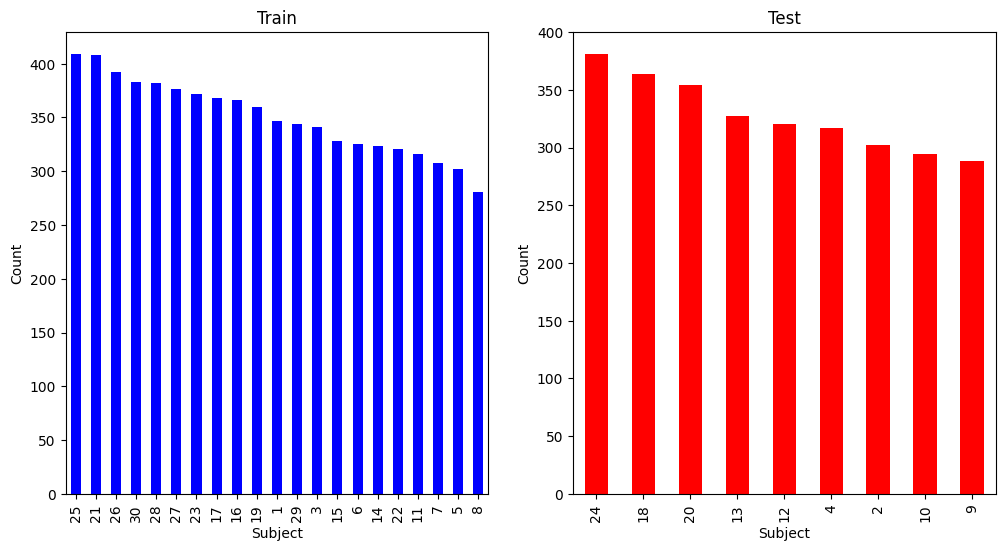

In [10]:
value_counts_train = train["subject"].value_counts()
value_counts_test = test["subject"].value_counts()

# plot the value counts
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
value_counts_train.plot(kind='bar', ax=ax[0], color='blue')
ax[0].set_title("Train")
ax[0].set_xlabel("Subject")
ax[0].set_ylabel("Count")
value_counts_test.plot(kind='bar', ax=ax[1], color='red')
ax[1].set_title("Test")
ax[1].set_xlabel("Subject")
ax[1].set_ylabel("Count")

plt.show()

# Data Preprocessing

In [3]:
def sliding_window(X, y=None, subject=None, window_size=100, overlap=0.5):
    # get the unique subject IDs
    subjects = np.unique(subject)
    X_new = []
    y_new = []
    subject_new = []

    for subject_id in subjects:
        # get the indices for the subject
        idx = np.where(subject == subject_id)[0]
        # get the data for the subject
        X_subject = X.iloc[idx, :]
        y_subject = y.iloc[idx] if y is not None else None
        # get the number of time points
        n_timepoints = X_subject.shape[0]
        # calculate step size (number of points to slide the window)
        step_size = int(window_size * (1 - overlap))
        # slide the window over the data
        start = 0
        while start + window_size <= n_timepoints:
            end = start + window_size
            X_temp = X_subject.iloc[start:end, :].to_numpy()

            # Ensure the window contains only one class, if y is provided
            if y is not None:
                y_temp = y_subject.iloc[start:end].to_numpy()

                # If the window contains multiple classes, adjust the end to contain one class
                if len(np.unique(y_temp)) != 1:
                    # Try to find a valid window that contains a single class
                    for j in range(start + 1, end):
                        if y_subject.iloc[j] != y_subject.iloc[start]:
                            end = j
                            break
                    # Ensure window is still of fixed size (pad if necessary)
                    X_temp = X_subject.iloc[start:end, :].to_numpy()
                    y_temp = y_subject.iloc[start:end].to_numpy()

                    # Pad the window to ensure fixed length
                    if len(X_temp) < window_size:
                        pad_size = window_size - len(X_temp)
                        X_temp = np.pad(X_temp, ((0, pad_size), (0, 0)), mode='edge')
                        y_temp = np.pad(y_temp, (0, pad_size), mode='edge')

                y_new.append(y_temp[0])  # Add the class of the window (single class)

            X_new.append(X_temp)  # Add the window to the results
            subject_new.append(subject_id)  # Add the subject ID for this window

            # move the window forward
            start += step_size

    return np.array(X_new), np.array(y_new)

In [4]:
y_train = train["Activity"]
X_train = train.drop(["Activity", "subject"], axis=1)
subject_train = train["subject"]

X_train, y_train = sliding_window(X_train, y_train, subject_train, window_size=30, overlap=0.5)

X_test = test.drop(["Activity", "subject"], axis=1)
y_test = test["Activity"]
subject_test = test["subject"]

X_test, y_test = sliding_window(X_test, y_test, subject_test, window_size=30, overlap=0.5)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((460, 30, 561), (460,), (184, 30, 561), (184,))

# Rocket Classifier

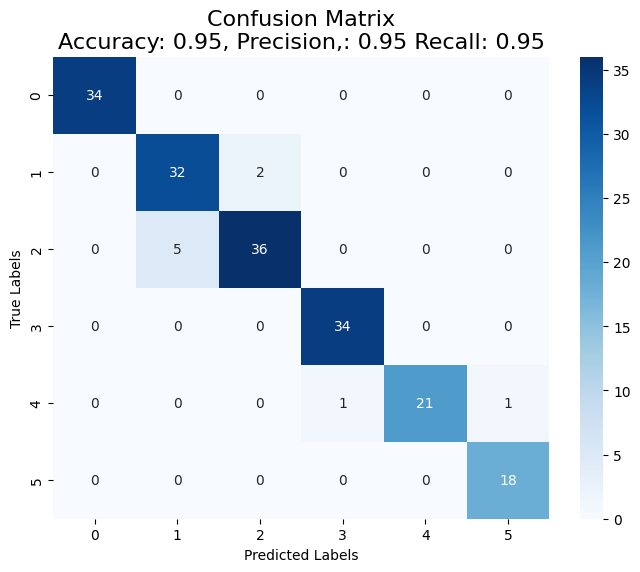

In [13]:
clf = RocketClassifier(num_kernels=500)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Add accuracy text above the confusion matrix
plt.title(f'Confusion Matrix\nAccuracy: {accuracy:.2f}, Precision,: {precision:.2f} Recall: {recall:.2f}', fontsize=16)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Show the plot
plt.show()

# Arsenal Classifier

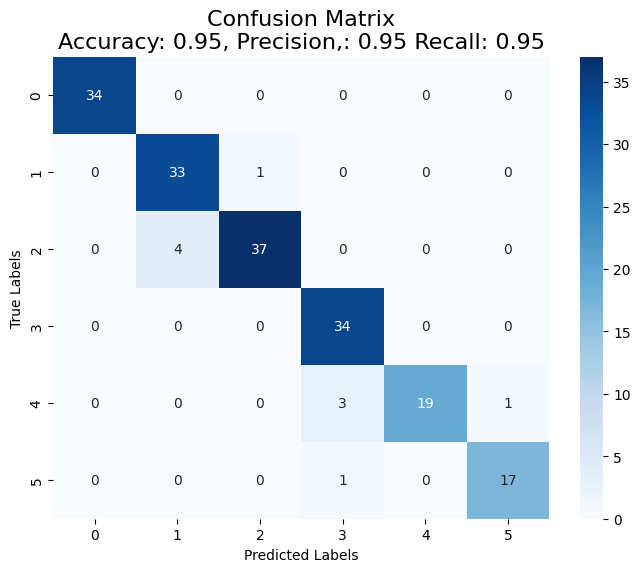

In [6]:
clf = Arsenal(num_kernels=100, n_estimators=5)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Add accuracy text above the confusion matrix
plt.title(f'Confusion Matrix\nAccuracy: {accuracy:.2f}, Precision,: {precision:.2f} Recall: {recall:.2f}', fontsize=16)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Show the plot
plt.show()

# Spiking Neural Networks

In [15]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

device

device(type='cpu')

In [37]:
X_train_tensors = Variable(torch.Tensor(X_train)).to(device)
X_test_tensors = Variable(torch.Tensor(X_test)).to(device)

# categorise y_train and y_test
y_train_preprocessed = np.zeros((y_train.shape[0], len(np.unique(y_train))))
y_test_preprocessed = np.zeros((y_test.shape[0], len(np.unique(y_train))))

for i in range(len(np.unique(y_train))):
    y_train_preprocessed[:, i] = (y_train == i).astype(int)
    y_test_preprocessed[:, i] = (y_test == i).astype(int)

y_train_tensors = Variable(torch.Tensor(y_train_preprocessed)).to(device)
y_test_tensors = Variable(torch.Tensor(y_test_preprocessed)).to(device)

X_train_tensors.shape, X_test_tensors.shape, y_train_tensors.shape,y_test_tensors.shape

(torch.Size([460, 30, 561]),
 torch.Size([184, 30, 561]),
 torch.Size([460, 6]),
 torch.Size([184, 6]))

In [38]:
train_dataset = TensorDataset(X_train_tensors, y_train_tensors)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test_tensors, y_test_tensors)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [47]:
# Define the model
class SNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_steps):
        super(SNNModel, self).__init__()

        # Spiking neuron with surrogate gradient for backpropagation
        beta = 0.9  # Leaky Integrate-and-Fire neuron decay rate
        self.spike = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid(slope=25))

        # Define layers
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)

        # Number of time steps
        self.num_steps = num_steps

        self.counter = 0
        self.min_validation_loss = float('inf')

    def forward(self, x):
        # Initialize membrane potential and spike state
        mem1 = self.spike.init_leaky()
        mem2 = self.spike.init_leaky()

        # Time steps loop
        spk_out = None
        for step in range(self.num_steps):
            # Forward pass for each time step
            cur_input = x[:, step, :]  # Extract features at the current time step

            mem1, spk1 = self.spike(self.fc1(cur_input), mem1)
            mem2, spk2 = self.spike(self.fc2(spk1), mem2)

            if spk_out is None:
                spk_out = spk2
            else:
                spk_out += spk2

        # Output classification (summing the spikes over time)
        return spk_out / self.num_steps  # Average spike activity across time steps

    def early_stop(self, validation_loss, min_delta, patience):
      if validation_loss < self.min_validation_loss:
          self.min_validation_loss = validation_loss
          self.counter = 0
      elif validation_loss > (self.min_validation_loss + min_delta):
          self.counter += 1
          if self.counter >= patience:
              return True
      return False

In [49]:
# Input shape: (batch_size=460, time_steps=30, input_size=561)
input_size = 561   # Features per time step
hidden_size = 256  # Number of neurons in hidden layer
num_classes = len(np.unique(y_train))   # Number of output classes (modify based on your problem)
num_steps = 30     # Number of time steps (sequence length)
learning_rate = 0.001 # Learning rate

model = SNNModel(input_size, hidden_size, num_classes, num_steps).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


history = {"loss":[], "accuracy":[], "val_loss":[], "val_accuracy":[]}

best_acc = 0

print("----------------------------------------------------------------------------------------------")

for epoch in range(100):
  batch_train_acc = []
  batch_train_loss = []
  with tqdm(total=len(train_dataloader), desc = 'Training batch') as pbar:
    for id_batch, (x_batch, y_batch) in enumerate(train_dataloader):
      model.train()
      outputs = model.forward(x_batch)
      optimizer.zero_grad()

      loss = criterion(outputs, y_batch)

      loss.backward()

      optimizer.step()

      batch_train_loss.append(loss.item())

      _, predicted = torch.max(outputs, 1)

      correct = torch.eq(torch.max(y_batch, 1)[1], predicted).sum().item()
      total = y_batch.size(0)
      batch_train_acc.append(correct / total)

      pbar.update(1)

  epoch_loss = np.average(batch_train_loss)
  history["loss"].append(epoch_loss)
  accuracy = np.average(batch_train_acc)
  history["accuracy"].append(accuracy)

  with torch.no_grad():
    batch_val_acc = []
    batch_val_loss = []
    with tqdm(total=len(train_dataloader), desc = 'Validation batch') as pbar:
      for id_batch, (x_batch, y_batch) in enumerate(train_dataloader):
        model.eval()
        val_outputs = model(x_batch)
        val_loss = criterion(val_outputs, y_batch)

        batch_val_loss.append(val_loss.item())

        _, val_predicted = torch.max(val_outputs, 1)
        val_correct = torch.eq(torch.max(y_batch, 1)[1], val_predicted).sum().item()
        val_total = y_batch.size(0)
        batch_val_acc.append(val_correct / val_total)

        pbar.update(1)

    epoch_val_loss = np.average(batch_val_loss)
    history["val_loss"].append(epoch_val_loss)
    val_accuracy = np.average(batch_val_acc)
    history["val_accuracy"].append(val_accuracy)

  print("Epoch: %d, Loss: %1.5f, Accuracy: %1.5f, Val Loss: %1.5f, Val Accuracy: %1.5f" % (epoch+1, epoch_loss, accuracy, epoch_val_loss, val_accuracy))
  print("----------------------------------------------------------------------------------------------")

  if best_acc < val_accuracy:
    best_acc = val_accuracy
    torch.save(model.state_dict(), f"best_model.pth")
  if model.early_stop(validation_loss=epoch_val_loss, min_delta=0, patience=5):
    break

----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/15 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1, Loss: 0.49526, Accuracy: 0.77765, Val Loss: 0.38470, Val Accuracy: 0.84430
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/15 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 2, Loss: 0.38503, Accuracy: 0.83963, Val Loss: 0.36270, Val Accuracy: 0.85256
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/15 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 3, Loss: 0.31717, Accuracy: 0.87341, Val Loss: 0.25335, Val Accuracy: 0.90212
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/15 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 4, Loss: 0.26820, Accuracy: 0.89502, Val Loss: 0.20450, Val Accuracy: 0.92318
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/15 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 5, Loss: 0.22349, Accuracy: 0.91386, Val Loss: 0.19171, Val Accuracy: 0.92704
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/15 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 6, Loss: 0.19044, Accuracy: 0.92708, Val Loss: 0.14939, Val Accuracy: 0.94576
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/15 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 7, Loss: 0.16722, Accuracy: 0.93652, Val Loss: 0.14157, Val Accuracy: 0.94893
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/15 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 8, Loss: 0.14646, Accuracy: 0.94538, Val Loss: 0.11797, Val Accuracy: 0.95677
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/15 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 9, Loss: 0.12860, Accuracy: 0.95319, Val Loss: 0.09059, Val Accuracy: 0.96806
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/15 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 10, Loss: 0.11789, Accuracy: 0.95758, Val Loss: 0.09793, Val Accuracy: 0.96586
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/15 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 11, Loss: 0.10667, Accuracy: 0.96136, Val Loss: 0.09009, Val Accuracy: 0.96792
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/15 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 12, Loss: 0.09556, Accuracy: 0.96556, Val Loss: 0.09483, Val Accuracy: 0.96751
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/15 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 13, Loss: 0.09156, Accuracy: 0.96714, Val Loss: 0.11579, Val Accuracy: 0.95994
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/15 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 14, Loss: 0.08483, Accuracy: 0.97036, Val Loss: 0.08766, Val Accuracy: 0.96806
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/15 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 15, Loss: 0.07845, Accuracy: 0.97243, Val Loss: 0.09704, Val Accuracy: 0.96297
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/15 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 16, Loss: 0.07468, Accuracy: 0.97236, Val Loss: 0.09561, Val Accuracy: 0.96985
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/15 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 17, Loss: 0.07182, Accuracy: 0.97399, Val Loss: 0.06102, Val Accuracy: 0.98114
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/15 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 18, Loss: 0.06694, Accuracy: 0.97651, Val Loss: 0.06439, Val Accuracy: 0.97756
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/15 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 19, Loss: 0.06512, Accuracy: 0.97695, Val Loss: 0.06668, Val Accuracy: 0.97825
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/15 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 20, Loss: 0.05957, Accuracy: 0.97795, Val Loss: 0.06635, Val Accuracy: 0.97605
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/15 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 21, Loss: 0.05876, Accuracy: 0.97860, Val Loss: 0.08374, Val Accuracy: 0.97081
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/15 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 22, Loss: 0.05789, Accuracy: 0.97882, Val Loss: 0.05952, Val Accuracy: 0.97839
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/15 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 23, Loss: 0.05529, Accuracy: 0.97926, Val Loss: 0.06721, Val Accuracy: 0.97550
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/15 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 24, Loss: 0.05171, Accuracy: 0.98092, Val Loss: 0.06989, Val Accuracy: 0.97701
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/15 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 25, Loss: 0.05103, Accuracy: 0.98075, Val Loss: 0.07809, Val Accuracy: 0.97632
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/15 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 26, Loss: 0.04675, Accuracy: 0.98231, Val Loss: 0.07271, Val Accuracy: 0.97770
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/15 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 27, Loss: 0.04972, Accuracy: 0.98241, Val Loss: 0.05946, Val Accuracy: 0.97907
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/15 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 28, Loss: 0.04661, Accuracy: 0.98378, Val Loss: 0.06623, Val Accuracy: 0.97907
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/15 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 29, Loss: 0.04409, Accuracy: 0.98383, Val Loss: 0.05942, Val Accuracy: 0.98045
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/15 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 30, Loss: 0.04000, Accuracy: 0.98458, Val Loss: 0.05854, Val Accuracy: 0.98224
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/15 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 31, Loss: 0.04341, Accuracy: 0.98453, Val Loss: 0.06680, Val Accuracy: 0.97839
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/15 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 32, Loss: 0.03981, Accuracy: 0.98560, Val Loss: 0.07005, Val Accuracy: 0.97825
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/15 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 33, Loss: 0.04377, Accuracy: 0.98341, Val Loss: 0.04754, Val Accuracy: 0.98238
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/15 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 34, Loss: 0.03829, Accuracy: 0.98610, Val Loss: 0.06886, Val Accuracy: 0.97673
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/15 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 35, Loss: 0.03585, Accuracy: 0.98671, Val Loss: 0.07460, Val Accuracy: 0.98004
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/15 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 36, Loss: 0.03558, Accuracy: 0.98715, Val Loss: 0.07384, Val Accuracy: 0.97687
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/15 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 37, Loss: 0.03442, Accuracy: 0.98753, Val Loss: 0.05718, Val Accuracy: 0.98265
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/15 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 38, Loss: 0.03354, Accuracy: 0.98799, Val Loss: 0.05586, Val Accuracy: 0.98265
----------------------------------------------------------------------------------------------


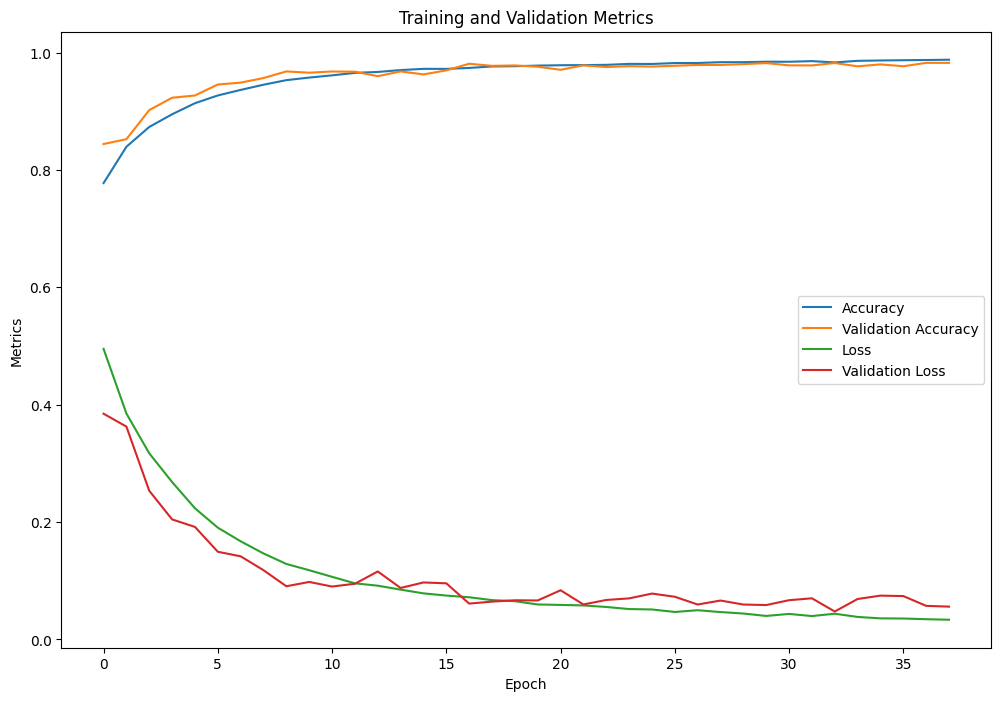

In [51]:
plt.figure(figsize=(12, 8))
plt.plot(history['accuracy'], label='Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.plot(history['loss'], label='Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.title('Training and Validation Metrics')
plt.show()

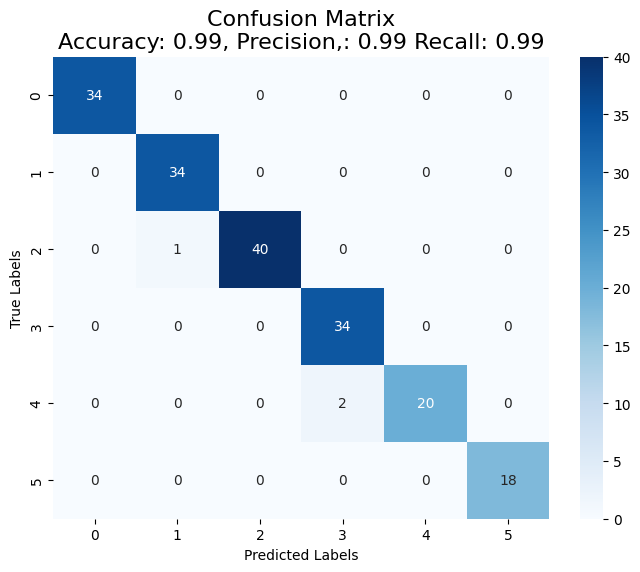

In [10]:
model.load_state_dict(torch.load("/content/best_model.pth"))

y_pred = []
y_real = []
with torch.no_grad():
    batch_test_acc = []
    with tqdm(total=len(test_dataloader), desc = 'Testing') as pbar:
      for id_batch, (x_batch, y_batch) in enumerate(test_dataloader):
        model.eval()
        test_outputs = model(x_batch)

        _, test_predicted = torch.max(test_outputs, 1)
        y_real.extend(torch.max(y_batch, 1)[1].cpu().data.numpy())
        y_pred.extend(test_predicted.cpu().data.numpy())
        test_correct = torch.eq(torch.max(y_batch, 1)[1], test_predicted).sum().item()
        test_total = y_batch.size(0)
        batch_test_acc.append(test_correct / test_total)
        pbar.update(1)

test_accuracy = np.average(batch_test_acc)

precision = precision_score(y_real, y_pred, average='weighted')
recall = recall_score(y_real, y_pred, average='weighted')
f1 = f1_score(y_real, y_pred, average='weighted')

cm = confusion_matrix(y_real, y_pred)

plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Add accuracy text above the confusion matrix
plt.title(f'Confusion Matrix\nAccuracy: {accuracy:.2f}, Precision,: {precision:.2f} Recall: {recall:.2f}', fontsize=16)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Show the plot
plt.show()